# DCGAN Implementation

Implementation of the (vanilla) Deep Convolutional Generative Adversarial Network defined by <a href="https://arxiv.org/pdf/1511.06434.pdf">Radford, Metz, and Chintala (2016)</a>.  Testing is done on the <a href="https://www.cs.toronto.edu/~kriz/cifar.html">CIFAR-10</a> benchmark image dataset, stored in pickled format in the `data/` directory.

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

import torch
import torch.nn as nn

## Load CIFAR Data

In [69]:
# Helper functions to convert CIFAR-10 to Pytorch Dataset

def unpickle(file):
    import pickle
    with open(file, 'rb') as in_file:
        pickle_dict = pickle.load(in_file, encoding='bytes')
    return pickle_dict


def read_data(file_name):
    """Given path to CIFAR data batch, returns raw X, y tensors."""
    
    batch_dict = unpickle(file_name)
    X_raw = torch.tensor(batch_dict[b'data']).float()
    y_raw = torch.tensor(batch_dict[b'labels']).long()
    return X_raw, y_raw


def shape_image(X):
    """Reshapes raw data tensor to nn.module-compatible RGB image"""
    
    # Each row of X_raw contains RGB color channels concatenated in row-major order
    # Need to first split channels into dim 1 on tensor, then shape dim 2/3 into image
    image_size = 32*32
    X = torch.split(X.unsqueeze(dim=1), image_size, dim=2)
    X = torch.cat(X, dim=1)
    X = X.view(-1, 3, 32, 32)   # (N, channels, pixel rows, pixel cols)
    return X


def normalize(X, a=-1, b=1):
    """Normalizes data tensor to [a, b] using min-max scaling."""
    
    data_min = torch.min(X).float().item()
    data_max = torch.max(X).float().item()
    assert a < b, "Rescaled range [a, b] must have a < b"
    
    # First scale to [0, 1], then rescale to [a, b]
    X = (X - data_min) / (data_max - data_min)
    X = (X * (b - a)) + a  
    return X


class CIFARDataset(torch.utils.data.Dataset):
    """Custom Dataset class which preprocesses and stores datasets
       from CIFAR batch files.  Works for CIFAR-10 and CIFAR-100."""
    
    def __init__(self, file_list, use_cuda=False):
        # Get list of (X, y) tuples, concatenate corresponding tensors
        combined_list = [read_data(file_name) for file_name in file_list]
        X_list, y_list = list(zip(*combined_list))
        X = torch.cat(X_list, dim=0)
        y = torch.cat(y_list, dim=0)
        
        self.data = normalize(shape_image(X))
        self.labels = y
        
    def __len__(self):
        return self.data.shape[0]
    
    def __getitem__(self, index):
        # Generates an (X, y) pair at given index
        return self.data[index, :], self.labels[index]

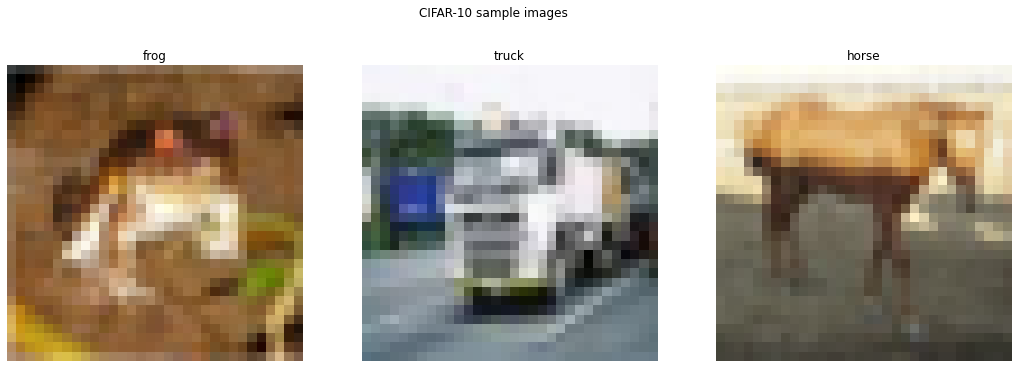

In [92]:
train_set = CIFARDataset([f"data/data_batch_{n}" for n in range(1, 6)])
test_set = CIFARDataset(["data/test_batch"])
cifar_meta = unpickle("data/batches.meta")

# Visualize a few random examples
fig, ax = plt.subplots(1, 3, figsize=(18, 6))
for i in range(3):
    X, y = train_set[i*1000]
    image = (X.squeeze().permute(1, 2, 0) + 1) / 2
    ax[i].imshow(image)
    ax[i].axis("off")
    ax[i].set_title(cifar_meta[b'label_names'][y.item()].decode('ascii'))
plt.suptitle("CIFAR-10 sample images")
plt.show()